## A/B - тестирование


В папке присутствует файл ab_test_ensembles.csv, который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы: нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

Загружаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from datetime import date, datetime

sns.set_theme(style="darkgrid")

##### Этап 1. Работа с данными
Загрузим наш датасет

In [2]:
data = pd.read_csv('ab_test_ensembles.csv')
data.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


В первую очередь рассмотрим краткую информацию о датасете и обратим внимание на наличие пропусков в наших данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


Пропусков в наших данных нет.

В наших данных есть столбец timestamp типа object. 
Мы можем подробнее посмотреть на период нашего эксперимента, а так же на взаимосвязь конверсий с днями недели и временем

In [4]:
data['timestamp'] = data['timestamp'].astype('datetime64[ns]')
data['date'] = data['timestamp'].dt.date
data['weekday'] = data['timestamp'].dt.dayofweek + 1
data['hour'] = data['timestamp'].dt.hour
data.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user,2022-05-21,6,22
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user,2022-05-12,4,8
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user,2022-05-11,3,16
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user,2022-05-08,7,18
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user,2022-05-21,6,1


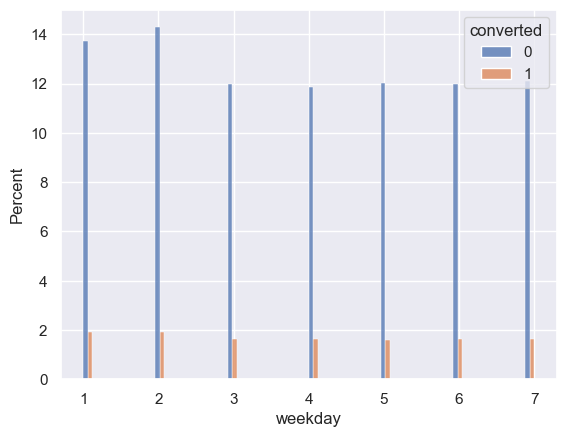

In [5]:
sns.histplot(data=data, x='weekday', hue='converted', multiple="dodge", stat='percent')
plt.show()

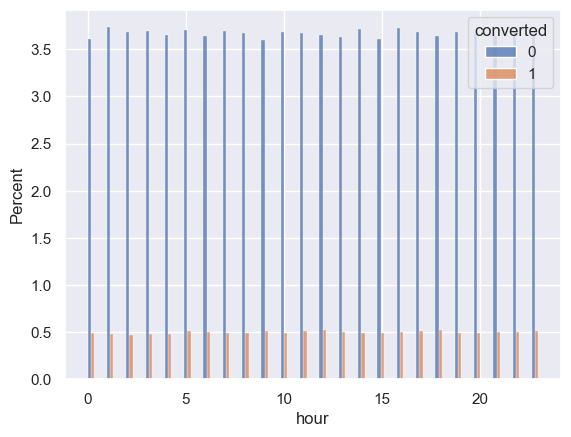

In [6]:
sns.histplot(data=data, x='hour', hue='converted', multiple="dodge", stat='percent')
plt.show()

Как видно из графиков, наши конвесии равномерно распределены по дням недели и часам. Ничего интересного мы не выяснили.

Теперь можем посмотреть более подробную статистику по столбцам датасета:

In [7]:
data.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,294478,294478,9109b0dc-d393-497f-8d63-ba9a25dd16b4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,294478,NaN,NaN,NaN,2022-05-13 13:40:10.474213120,2022-05-02 13:42:05.378582,2022-05-08 02:06:48.649925120,2022-05-13 13:21:07.016475904,2022-05-19 01:43:51.611873792,2022-05-24 13:41:54.460509,NaN
group,294478,2,treatment,147276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variants,294478,2,standard,147239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted,294478.0,NaN,NaN,NaN,0.119659,0.0,0.0,0.0,0.0,1.0,0.324563
location,294478,1,United Kingdom,294478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_group,294478,6,26-33,49270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_type,294478,2,registered_user,147240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,294478,23,2022-05-08,13564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,294478.0,NaN,NaN,NaN,3.891269,1.0,2.0,4.0,6.0,7.0,2.024641


Как можно увидеть из описания датасета, все user_id в нем уникальны.

По описанию timestamp увидим, что наш эксперимент длился 22 дня. 

Параметр location по сути смысловой нагрузки не несет, так как все данные у нас из одной страны.

Показатель age_group в нашем датасете имеет 6 диапазонов возраста. Имеет смысл посмотреть как распределены наши возрастные группы, чтобы понимать каким способом лучше делать выборку из наших данных (Simple Random или Stratified Random). Так же есть столбец user_type, который тоже следует рассмотреть.

In [8]:
data['age_group'].value_counts(normalize=True)

age_group
26-33    0.167313
50-57    0.167177
58+      0.167014
42-49    0.166800
34-41    0.166063
18-25    0.165632
Name: proportion, dtype: float64

Наши данные разделены по группам плюс/минус равномерно, соответственно мы можем использовать для выборки обычный рандом.

Можем дополнительно посмотреть на распределение еще и по user_type.

In [9]:
data[['user_type', 'age_group']].value_counts(normalize=True)

user_type        age_group
registered_user  58+          0.083993
new_user         26-33        0.083864
                 50-57        0.083860
                 42-49        0.083527
registered_user  26-33        0.083449
                 34-41        0.083405
                 50-57        0.083317
                 42-49        0.083273
new_user         18-25        0.083066
                 58+          0.083021
                 34-41        0.082658
registered_user  18-25        0.082566
Name: proportion, dtype: float64

Совместное распределение данных по категориям user_type и age_group так же очень равномерно, таким образом мы удостоверились, что использование простого рандома нам не повредит.

##### Этап 2. Определение задачи и формулировка гипотез

Нам предоставили данные о текущем среднем уровне конверсии за год, который составляет 13%. Мы предполагаем, что новая версия сайта увеличит наш уровень конверсий на 2%, т.е. до 15%.

Для начала стоит протестировать есть ли вообще какое-то влияние нового вида сайта на уровень конверсий. Сформулируем наши гипотезы:

В нулевой гипотезе будем предполагать, что конверсии при использовании новой версии сайта остались на прежнем уровне, альтернативная гипотеза будет заключаться в том, что уровень конверсий при использовании нового дизайна сайта изменился.

Наши гипотезы будут выглядеть следующим образом:

$H_0: p = p_0$

$H_1: p \ne p_0$,


где $p_0$ - уровень конверсий старого варианта сайта, $p$ - уровень конверсий нового варианта сайта.

In [10]:
conversion_level = 0.13
conversion_level_expected = 0.15

Для проведения A/B тестирования нам необходимо 2 группы:
1. Контрольная (Control) группа - та группа пользователей, которым будет показываться старая версия сайта.
2. Эксперементальная (Treatment) группа - та группа пользователей, которым будет показываться новая версия сайта.

Проверим версию сайта, которую видят наши пользователи:

In [11]:
data.pivot_table(values='converted', index='group', columns='variants', aggfunc='count')

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Заметим, что есть часть пользователей из контрольной группы, которая пользовалась новой версией сайта, и наоборот. 
Для нашего эксперимента эти данные не нужны.

In [12]:
df = data[((data['group'] == 'treatment') & (data['variants'] == 'svm_ensemble_v_1_22')) | ((data['group'] == 'control') & (data['variants'] == 'standard'))]

In [13]:
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user,2022-05-21,6,22
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user,2022-05-12,4,8
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user,2022-05-11,3,16
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user,2022-05-08,7,18
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user,2022-05-21,6,1


In [14]:
df.pivot_table(values='converted', index='group', columns='variants', aggfunc='count')

variants,standard,svm_ensemble_v_1_22
group,,
control,145274.0,NaN
treatment,NaN,145311.0


Теперь определимся с количеством необходимых нам данных:

Анализ мощности выборки зависит от нескольких факторов:
1. Мощность теста (1 - бетта) - представляет собой вероятность найти статистические различия между групами в тесте если действительно существует разница между групами. Обычно кастомным показателем в большинстве тестов выбирают 0.8
2. Альфа фактов (альфа) - критическое значение, которое мы установили выше 0.05
3. Эффект/Размер эффекта - то, насколько сильна разница между двумя целевыми показателям (нам необходимо 2% между двумя групами).

In [15]:
effect_size = sms.proportion_effectsize(conversion_level, conversion_level_expected)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n = ceil(required_n)
print(f'Для каждой группы нам необходимо не менее {required_n} наблюдений')

Для каждой группы нам необходимо не менее 4720 наблюдений


У нас имеется 145 тыс. наблюдений для каждой группы, что сильно больше необходимого количества наблюдений.

Для соответствия групп и удобства достанем случайным образом по 145 тыс. пользователей для каждой группы испытуемых. 

In [16]:
group_count = 145_000

In [17]:
control_sample = df[df['group'] == 'control'].sample(n = group_count, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n = group_count, random_state=42)

# Сформируем общую случайную выборку
ab_data = pd.concat([control_sample, treatment_sample], axis=0)
ab_data.reset_index(drop=True, inplace=True)
ab_data.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,2818e9bf-53e6-49c5-b99c-334f43f212ed,2022-05-10 09:09:40.751637,control,standard,0,United Kingdom,34-41,registered_user,2022-05-10,2,9
1,1c408718-c9db-4aad-8a3b-f2ecd239eee5,2022-05-13 22:27:34.228088,control,standard,0,United Kingdom,18-25,new_user,2022-05-13,5,22
2,3f7ead5e-67f3-4992-9d4f-c27b7699527e,2022-05-08 07:36:16.560979,control,standard,0,United Kingdom,42-49,registered_user,2022-05-08,7,7
3,5bd23952-1f0e-467d-83d1-b9d9230057f3,2022-05-14 15:35:18.212769,control,standard,0,United Kingdom,34-41,registered_user,2022-05-14,6,15
4,34b99951-b9a9-41cf-adc4-aeb9fe04cc9b,2022-05-20 17:02:53.291693,control,standard,0,United Kingdom,18-25,registered_user,2022-05-20,5,17
5,8a42f811-8273-4ccd-8706-653b6cfd8850,2022-05-14 01:10:40.032709,control,standard,1,United Kingdom,50-57,registered_user,2022-05-14,6,1
6,bcdcbb95-e757-4970-a4c9-4c8c0a696b85,2022-05-05 02:19:37.285535,control,standard,0,United Kingdom,42-49,registered_user,2022-05-05,4,2
7,6ee91c96-06d6-4fa5-8485-5a897308092a,2022-05-20 16:19:42.254953,control,standard,0,United Kingdom,26-33,new_user,2022-05-20,5,16
8,501239c5-c76b-4f34-abc4-1113ccf49a9f,2022-05-20 21:48:38.772674,control,standard,0,United Kingdom,26-33,registered_user,2022-05-20,5,21
9,e3c5aa94-f592-4687-951b-bb9382d983c6,2022-05-17 12:55:03.495945,control,standard,0,United Kingdom,42-49,registered_user,2022-05-17,2,12


Посмотрим информацию о нашей выборке:

In [18]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290000 entries, 0 to 289999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290000 non-null  object        
 1   timestamp  290000 non-null  datetime64[ns]
 2   group      290000 non-null  object        
 3   variants   290000 non-null  object        
 4   converted  290000 non-null  int64         
 5   location   290000 non-null  object        
 6   age_group  290000 non-null  object        
 7   user_type  290000 non-null  object        
 8   date       290000 non-null  object        
 9   weekday    290000 non-null  int32         
 10  hour       290000 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(7)
memory usage: 22.1+ MB


Проверим на всякий случай, что контрольная и тестовая группы в нашей выборке представлены одинаково

In [19]:
ab_data.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

##### 3. Этап визуализации
Вычислим необходимые статистики для нашей конверсии

In [20]:
conversion_rates = ab_data.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120441,0.325477,0.000855
treatment,0.118841,0.323602,0.000850


По нашей таблице кажется, что новая версия сайта не произвела должного эффекта, но мы все же проверим

Изобразим наш уровень конверсий в разрезе групп на графике:

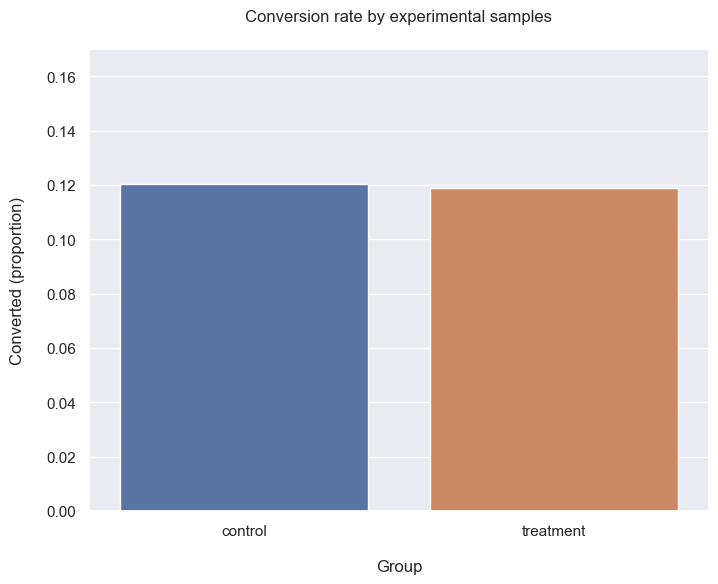

In [21]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_data['group'], y=ab_data['converted'], errorbar=('ci', False), hue=ab_data['group']);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

##### 4. Этап тестирования гипотезы

Здесь мы воспользуемся замечательной библиотекой statsmodels.
Так как у нас много данных, мы можем использовать z-test.

In [22]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_data[ab_data['group'] == 'control']['converted']
treatment_results = ab_data[ab_data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.33
p-value: 0.184
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Так как наше $p = 0.184$, что является высоким показателем по сравнению с выбранным $\alpha = 0.05$, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу $H_0$. Т. е. новая версия сайта никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы $[0.117, 0.121]$ или $11,7\%-12,1\%$ соответственно:

Он включает наш baseline.    
Он не достигает нашей цели в 15% конверсии.    
Мы можем интерпретировать это так: наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline. Очень маловероятно, что новый уровень конверсии будет близок к 15%, который мы определили по нашей цели.

##### Этап 5. Повторение эксперимента, но уже с разделением на группы new_user/registered_user

Теперь разделим наш датасет на группы:

In [23]:
data_new_users = df[df['user_type'] == 'new_user']
data_reg_users = df[df['user_type'] == 'registered_user']

In [24]:
data_new_users.reset_index(drop=True, inplace=True)
data_new_users.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user,2022-05-11,3,16
1,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user,2022-05-04,3,17
2,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user,2022-05-15,7,18
3,1cc7ebbb-efb9-43a6-9230-11161ae910ba,2022-05-21 22:37:47.774891,treatment,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user,2022-05-21,6,22
4,137d7bf0-309c-4aad-ad9e-302a2f45dc70,2022-05-22 11:45:11.327945,treatment,svm_ensemble_v_1_22,0,United Kingdom,50-57,new_user,2022-05-22,7,11


In [25]:
data_reg_users.reset_index(drop=True, inplace=True)
data_reg_users.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user,2022-05-21,6,22
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user,2022-05-12,4,8
2,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user,2022-05-08,7,18
3,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user,2022-05-21,6,1
4,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user,2022-05-10,2,15


В сущности производим те же манипуляции, только с датасетом по новым пользователям:    
\* необходимое количество данных в выборке остается прежним, т.к. мы пытаемся определить увеличение конверсии с 13% до 15% с теми же параметрами.

Теперь нужно понять, сколько сэмплов мы можем взять из каждой группы:

In [26]:
min(data_new_users[data_new_users['group'] == 'control'].shape[0],
data_new_users[data_new_users['group'] == 'treatment'].shape[0])

72482

Теперь у нас есть 72 тыс. сэмплов на каждую группу, что сильно больше необходимого количества в 4720 наблюдений.

In [27]:
new_users_group_count = 72_000

In [28]:
control_sample_new_users = data_new_users[data_new_users['group'] == 'control'].sample(n = new_users_group_count, random_state=42)
treatment_sample_new_users = data_new_users[data_new_users['group'] == 'treatment'].sample(n = new_users_group_count, random_state=42)

# Сформируем общую случайную выборку
ab_data_new_users = pd.concat([control_sample_new_users, treatment_sample_new_users], axis=0)
ab_data_new_users.reset_index(drop=True, inplace=True)
ab_data_new_users.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,d537fe14-23d0-4a71-ad6c-c4502ab3299e,2022-05-23 03:36:33.388524,control,standard,0,United Kingdom,18-25,new_user,2022-05-23,1,3
1,3dc13667-413c-4729-9904-ba0c72bddb84,2022-05-05 03:31:16.543145,control,standard,0,United Kingdom,26-33,new_user,2022-05-05,4,3
2,f6818045-16a2-43fb-a891-ade8c98f8466,2022-05-21 01:15:15.711131,control,standard,0,United Kingdom,34-41,new_user,2022-05-21,6,1
3,fe791ea1-a90a-4bd4-8ce8-17b13420a482,2022-05-03 18:36:20.055898,control,standard,0,United Kingdom,34-41,new_user,2022-05-03,2,18
4,e4ed1ed8-a9be-4494-a42c-18cc73f5321c,2022-05-02 19:56:20.904862,control,standard,0,United Kingdom,42-49,new_user,2022-05-02,1,19
5,1f901090-d8aa-4260-b089-f4f48f62a7ff,2022-05-11 04:10:43.145638,control,standard,0,United Kingdom,26-33,new_user,2022-05-11,3,4
6,2fd53d21-e169-47a7-95f0-4baf72ed3ce1,2022-05-04 22:42:39.273964,control,standard,0,United Kingdom,58+,new_user,2022-05-04,3,22
7,78dae346-4291-47af-966e-181fe0cf09f5,2022-05-06 16:37:17.224118,control,standard,1,United Kingdom,18-25,new_user,2022-05-06,5,16
8,0d64a192-e84b-40ec-968c-0ba32a8b5145,2022-05-05 01:55:06.679210,control,standard,0,United Kingdom,58+,new_user,2022-05-05,4,1
9,b1ea89e4-c019-447a-a5f2-07f7ede70d52,2022-05-09 22:56:53.919969,control,standard,1,United Kingdom,58+,new_user,2022-05-09,1,22


In [29]:
conversion_rates_new_users = ab_data_new_users.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion_new_users = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion_new_users = lambda x: stats.sem(x, ddof=0)

conversion_rates_new_users = conversion_rates_new_users.agg(['mean', std_proportion_new_users, se_proportion_new_users]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_new_users

,CR mean,CR std,CR se
group,,,
control,0.120861,0.325966,0.001215
treatment,0.117292,0.321768,0.001199


Видим, что конвесия по новым пользователям немного меньше, чем в целом

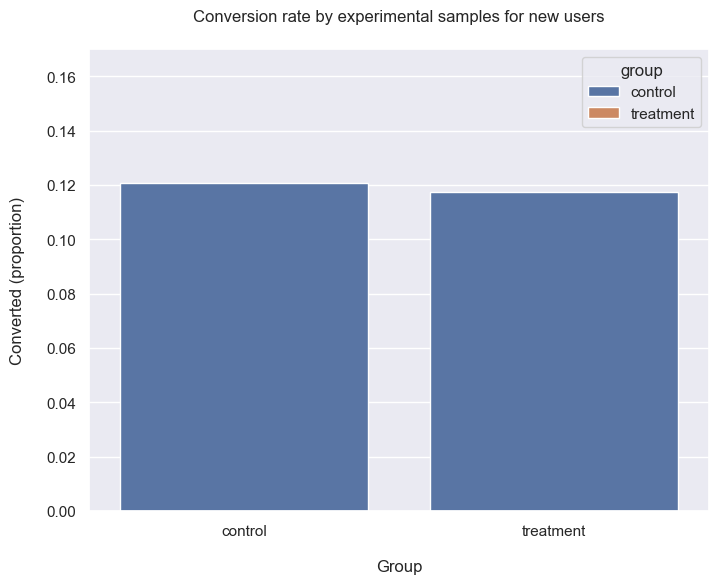

In [30]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_data_new_users['group'], y=ab_data_new_users['converted'], errorbar=('ci', False), hue=ab_data['group']);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples for new users', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

Проводим z-test:

In [31]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_new_users = ab_data_new_users[ab_data_new_users['group'] == 'control']['converted']
treatment_results_new_users = ab_data_new_users[ab_data_new_users['group'] == 'treatment']['converted']

n_con_new_users = control_results_new_users.count()
n_treat_new_users = treatment_results_new_users.count()
successes_new_users = [control_results_new_users.sum(), treatment_results_new_users.sum()]
nobs_new_users = [n_con_new_users, n_treat_new_users]

z_stat, pval = proportions_ztest(successes_new_users, nobs=nobs_new_users)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes_new_users, nobs=nobs_new_users, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 2.09
p-value: 0.037
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]


Наш $p = 0.037$, что меньше задаваемого $\alpha = 0.05$. Соответственно, нулевую гипотезу $H_0$ мы можем отклонить.
Очень вероятно, что новая версия сайта оказывает некое влияние на конверсии новых пользователей.

Доверительный интервал для испытуемой группы $[0.115, 0.120]$ или $11,5\%-12,0\%$ соответственно:

Он включает наш baseline (но уже верхней границей).    
Он не достигает нашей цели в 15% конверсии.

Мы можем интерпретировать это так: наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет отличен от baseline. Очень маловероятно, что новый уровень конверсии будет близок к 15%, который мы определили по нашей цели, а сильно вероятно, что конверсии на новой версии сайта для новых пользователей и вовсе снизятся. 


Соответственно, не рекомендуется переходить на новую версию сайта для группы новых клиентов.

Проделаем тоже самое для старых пользователей:

In [32]:
min(data_reg_users[data_reg_users['group'] == 'control'].shape[0],
data_reg_users[data_reg_users['group'] == 'treatment'].shape[0])

72483

Теперь у нас есть 72 тыс. сэмплов на каждую группу, что сильно больше необходимого количества в 4720 наблюдений.

In [33]:
reg_users_group_count = 72_000

In [34]:
control_sample_reg_users = data_reg_users[data_reg_users['group'] == 'control'].sample(n = reg_users_group_count, random_state=42)
treatment_sample_reg_users = data_reg_users[data_reg_users['group'] == 'treatment'].sample(n = reg_users_group_count, random_state=42)

# Сформируем общую случайную выборку
ab_data_reg_users = pd.concat([control_sample_reg_users, treatment_sample_reg_users], axis=0)
ab_data_reg_users.reset_index(drop=True, inplace=True)
ab_data_reg_users.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type,date,weekday,hour
0,d3f69e8d-6948-4c43-8a16-670a7bd7f8d1,2022-05-08 08:34:26.885923,control,standard,0,United Kingdom,26-33,registered_user,2022-05-08,7,8
1,a3d6238a-abe1-42f1-a846-a7d2207fee08,2022-05-15 00:35:00.991369,control,standard,0,United Kingdom,18-25,registered_user,2022-05-15,7,0
2,edce88aa-4b23-4864-b45b-503863495eda,2022-05-19 14:51:10.441226,control,standard,0,United Kingdom,34-41,registered_user,2022-05-19,4,14
3,08ebfa1e-7295-4acc-8380-3a05ec782cf3,2022-05-21 23:00:09.042497,control,standard,0,United Kingdom,58+,registered_user,2022-05-21,6,23
4,8ac4ad4f-7cc7-42e1-898f-b34568a621d3,2022-05-17 17:15:07.163625,control,standard,1,United Kingdom,34-41,registered_user,2022-05-17,2,17
5,79b9bc73-4b4d-4ca3-8a89-4d401fbcacb9,2022-05-06 07:11:09.003691,control,standard,0,United Kingdom,58+,registered_user,2022-05-06,5,7
6,fc55c48d-5737-4b54-82af-4f6d06ec4385,2022-05-04 07:53:54.224120,control,standard,0,United Kingdom,58+,registered_user,2022-05-04,3,7
7,74d4b355-da0b-487f-a5a1-a0eb2d67153e,2022-05-08 23:33:45.782835,control,standard,1,United Kingdom,42-49,registered_user,2022-05-08,7,23
8,1570aebd-58cf-4950-9f4f-10a9c1d90e78,2022-05-08 15:32:12.107029,control,standard,0,United Kingdom,42-49,registered_user,2022-05-08,7,15
9,270b87a3-ebfb-4536-af4f-34ea9177d5b7,2022-05-23 20:10:58.706871,control,standard,0,United Kingdom,50-57,registered_user,2022-05-23,1,20


In [35]:
conversion_rates_reg_users = ab_data_reg_users.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion_reg_users = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion_reg_users = lambda x: stats.sem(x, ddof=0)

conversion_rates_reg_users = conversion_rates_reg_users.agg(['mean', std_proportion_reg_users, se_proportion_reg_users]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_reg_users

,CR mean,CR std,CR se
group,,,
control,0.119986,0.324945,0.001211
treatment,0.120278,0.325286,0.001212


In [36]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_reg_users = ab_data_reg_users[ab_data_reg_users['group'] == 'control']['converted']
treatment_results_reg_users = ab_data_reg_users[ab_data_reg_users['group'] == 'treatment']['converted']

n_con_reg_users = control_results_reg_users.count()
n_treat_reg_users = treatment_results_reg_users.count()
successes_reg_users = [control_results_reg_users.sum(), treatment_results_reg_users.sum()]
nobs_reg_users = [n_con_reg_users, n_treat_reg_users]

z_stat, pval = proportions_ztest(successes_reg_users, nobs=nobs_reg_users)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes_reg_users, nobs=nobs_reg_users, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.17
p-value: 0.865
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


Наш $p = 0.865$, что так же существенно больше задаваемого $\alpha = 0.05$. Соответственно, нулевую гипотезу $H_0$ мы отклонить не можем.
Очень вероятно, что новая версия сайта на конверсии старых пользователей особого влияния не оказывает.

Так же доверительный интервал для нашей величины конверсий и близко не содержит $15\%$, что говорит нам о том, что новая версия сайта очень вероятно не даст нам конверсии для старых пользователей в $15\%$.

Вывод: Таким образом, внедрять новую версию сайта не рекомендуется, т.к. на общий уровень конверсий это скорее всего не повлияет, однако для новых пользователей нашего сайта это может привести к небольшому снижению конверсий.